In [329]:
import numpy as np
import random as r
import matplotlib.pyplot as plt
import json
import os

In [353]:
class Intersection:
    def __init__ (self, capacity):
        self.cars = [[], [], [], []] #上右下左，包含每个车的等待时间
        self.spawn_rate = 0.3
        self.capacity = capacity
        self.light_status = 0 # 0左右开， 1上下开
        self.count_down = 0 # 计量黄灯时间
        #self.nextcars = [[0, 0, 0, 0]

    def reset(self):
        self.cars = [[], [], [], []]
        self.light_status = 0
        self.count_down = 0

    def is_end_state(self):
        return sum([len(self.cars[i]) >= self.capacity for i in range(4)])

    def get_score(self):
        return self.cal_score(self.cars, self.countdown)     
        
    def cal_score(self, carstate, countdownnum):
        score = 1000
        score -= sum([sum(x) for x in carstate])
        score -= countdownnum * 2
        return score

    def cal_reward(self, action):
        reward = self.capacity
        if ((action == 0) == (self.light_status == 0)):
            #for i in [0, 2]:
                #reward += int(len(self.cars[i]) * 0.3)
            reward += max([int(len(self.cars[i]) * 0.3) for i in [0, 2]])
            #for i in [1, 3]:
            #    reward -= ((len(self.cars[i]) * len(self.cars[i])) / self.capacity)
            reward -= max([((len(self.cars[i]) * len(self.cars[i])) / self.capacity) for i in [1, 3]])
        else:
            #for i in [1, 3]:
            #    reward += int(len(self.cars[i]) * 0.3)
            reward += max([int(len(self.cars[i]) * 0.3) for i in [1, 3]])
            #for i in [0, 2]:
            #    reward -= ((len(self.cars[i]) * len(self.cars[i])) / self.capacity)
            reward -= max([((len(self.cars[i]) * len(self.cars[i])) / self.capacity) for i in [0, 2]])

        #if ((action == 1) and len(self.cars[i]))
        
        #if ((action == 0) == (self.light_status == 0)):
            #for i in [0, 2]:
            #    if (len(self.cars[i]) > self.capacity - 3):
            #        reward += 
            #    reward += ((len(self.cars[i]) ** 2) / self.capacity)
            #for i in [1, 3]:
                #reward -= ((len(self.cars[i]) * len(self.cars[i])) / self.capacity)
                #if len(self.cars[i]) > 0:
                #    reward += self.cars[i][0]
                    #reward += 1
        #else:
            #for i in [0, 2]:
                #reward -= ((len(self.cars[i]) * len(self.cars[i])) / self.capacity)
            #for i in [1, 3]:
            #    reward += ((len(self.cars[i]) ** 2) / self.capacity)
                #if len(self.cars[i]) > 0:
                #    reward += self.cars[i][0]
                    #reward += 1
        
        #reward -= self.count_down * 2
        #if (self.count_down != 0 and action == 1):
        #    reward -= 999999
        #for lane in self.cars:
        #    reward -= (len(lane) ** 2 / self.capacity)
        return reward

    def next_state(self, action):
        action = int(action)
        local_count_down = self.count_down
        if (local_count_down != 0):
                local_count_down -= 1
        local_nextcars = self.cars.copy()
        for i in range(4):
            if (r.random() < self.spawn_rate):
                local_nextcars[i].append(0)
        #print("action: {}".format(action))
        if (action == 0):
            #print(local_count_down)
            if (local_count_down == 0):
                #print(self.light_status)
                if (self.light_status == 0):
                    for i in [0, 2]:
                        if len(local_nextcars[i]) > 0:
                            local_nextcars[i].pop(0)
                else:
                    for i in [1, 3]:
                        if len(local_nextcars[i]) > 0:
                            local_nextcars[i].pop(0)
        else:
            #self.light_status = not self.light_status
            local_count_down = 2
        for i in range(len(local_nextcars)):
            for j in range(len(local_nextcars[i])):
                local_nextcars[i][j] += 1
        
        return (local_nextcars, local_count_down)

    def take(self, action, demo = False, print_ = True):
        action = int(action)
        if (demo):
            if (self.count_down != 0 and action == 1):
                if (print_):
                    print('action not taken')
                action = 0
        self.cars, self.count_down = self.next_state(action)
        if (action != 0):
            self.light_status = not self.light_status
        return
    
    def get_state(self):
        return [len(x) for x in self.cars]
    
    def cal_state(self, state):
        return [len(x) for x in state]

    def print_state(self):
        print(self.cars)
        print('light: {}, count: {}'.format(self.light_status, self.count_down))
        
def l2s(l_list):
    t_list = [str(num) for num in l_list]
    return ' '.join(t_list)

class QLP:
    def __init__(self, alpha, epsilon, gamma, num_train, capacity):
        self.alpha = float(alpha)
        self.epsilon = float(epsilon)
        self.gamma = float(gamma)
        self.num_train = int(num_train)
        self.capacity = capacity
        self.qtable = {}

        curKey = [0, 0, 0, 0]
        for i in range(capacity ** 4):
            for j in range(4):
                if (curKey[3 - j] == capacity - 1):
                    curKey[3 - j] = 0
                else:
                    curKey[3 - j] += 1
                    break
            for i in range(3):
                for j in range(2):
                    self.qtable[str(l2s(curKey + [i] + [j]))] = {'0' : 0, '1' : 0}
        #print(self.qtable)

    def choose_action(self, state):
        if r.random() > self.epsilon:
            return max(self.qtable[l2s(state)], key=self.qtable[l2s(state)].get)
        else:
            return 1 if r.random() < 0.5 else 0

    def train(self):
        cross = Intersection(self.capacity)
        train_step = 0
        while train_step < self.num_train:
            cross.reset()
            while not cross.is_end_state():
                if (train_step > self.num_train):
                    break
                print(train_step)
                state = cross.get_state() + [cross.count_down] + [int(cross.light_status)]
                action = self.choose_action(state)
                next_state, next_countdown = cross.next_state(action)
                if (sum([len(next_state[i]) >= self.capacity for i in range(4)]) != 0):
                    break
                reward = cross.cal_score(next_state, next_countdown)
                reward = cross.cal_reward(action)
                next_state = cross.cal_state(next_state) + [next_countdown] + [int(cross.light_status) if action == 0 else int(not cross.light_status)]
                
                sp_score = max(self.qtable[l2s(next_state)]['0'], self.qtable[l2s(next_state)]['1'])
                cur_q = (1 - self.alpha) * self.qtable[l2s(state)][str(action)] + self.alpha * (reward + self.gamma * sp_score)
                self.qtable[l2s(state)][str(action)] = cur_q
                cross.take(action)
                train_step += 1

    def get_action(self, state, print_ = True):
        if (print_):
            print('q val 0 = {}, q val 1 = {}, optimal = {}'.format(self.qtable[l2s(state)]['0'], self.qtable[l2s(state)]['1'], max(self.qtable[l2s(state)], key=self.qtable[l2s(state)].get)))
        return max(self.qtable[l2s(state)], key=self.qtable[l2s(state)].get)
    
    def dump(self, file_name):
        with open(file_name, 'w') as fp:
            json.dump(self.qtable, fp)

    def load(self, file_name):
        with open(file_name, 'r') as fp:
            self.qtable = json.load(fp)

def demo(qlp, demo_range = 10, print_ = True):
    cross = Intersection(qlp.capacity)
    cost = 0
    for i in range(demo_range):
        if (print_):
            print('\n# {}'.format(i))
        state = cross.cars
        for lane in state:
            cost += len(lane) * len(lane)
        if (print_):
            cross.print_state()
        state = cross.cal_state(state) + [cross.count_down] + [int(cross.light_status)]
        try:
            action = qlp.get_action(state, print_)
        except KeyError:
            break
            #if (cross.light_status == 1 and max([len(cross.cars[i]) for i in [0, 2]]) > 15):
            #    action = 1
            #elif (cross.light_status == 0 and max([len(cross.cars[i]) for i in [1, 3]]) > 15):
            #    action = 1
        if (print_):
            print(action)
        cross.take(action, demo = True, print_ = print_)
    if (print_):
        print('avg cost = {}'.format(cost / demo_range))
    return cost / demo_range

def demo_contrast(demo_range = 10, print_ = True):
    cross = Intersection(15)
    cost = 0
    for i in range(demo_range):
        if (print_):
            print('\n# {}'.format(i))
        state = cross.cars
        for lane in state:
            cost += len(lane) * len(lane)
        if (print_):
            cross.print_state()
        action = (i % 6 == 0)
        if (print_):
            print(action)
        cross.take(action, demo = True, print_ = print_)
    if (print_):
        print('avg cost = {}'.format(cost / demo_range))
    return cost / demo_range

In [346]:
ql = QLP(0.5, 0.4, 0.5, 1000000, 15)
file_name = 'qtable.json'
if (os.path.exists(file_name)):
    print('json loaded!')
    ql.load(file_name)
else:
    ql.train()
    print('json dumped!')
    ql.dump(file_name)


json loaded!


1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


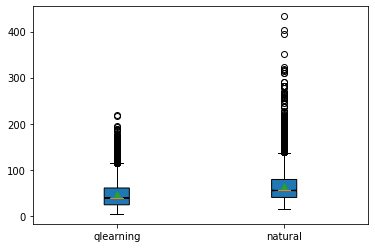

In [351]:
ql_data = []
natural_data = []
for i in range(5000):
    print(i)
    ql_data.append(demo(ql, 500, False))
    natural_data.append(demo_contrast(500, False))

labels = ['qlearning', 'natural']
plt.boxplot([ql_data, natural_data], showmeans=True, notch = True, patch_artist=True, labels=labels)

plt.show()

In [354]:
#print(ql.qtable)
#print(ql.qtable)
demo(ql, 100)


# 0
[[], [], [], []]
light: 0, count: 0
q val 0 = 29.79373115631198, q val 1 = 29.7334648571938, optimal = 0
0

# 1
[[], [], [], []]
light: 0, count: 0
q val 0 = 29.79373115631198, q val 1 = 29.7334648571938, optimal = 0
0

# 2
[[], [1], [], []]
light: 0, count: 0
q val 0 = 29.74521333366476, q val 1 = 29.71104074748008, optimal = 0
0

# 3
[[], [2, 1], [], [1]]
light: 0, count: 0
q val 0 = 29.185302810351192, q val 1 = 29.57641580439332, optimal = 1
1

# 4
[[], [3, 2], [], [2]]
light: True, count: 2
q val 0 = 28.71878272691525, q val 1 = 29.28293020207485, optimal = 1
1
action not taken

# 5
[[1], [4, 3], [], [3]]
light: True, count: 1
q val 0 = 29.100429153051248, q val 1 = 29.326315165985434, optimal = 1
1
action not taken

# 6
[[2], [4, 1], [], [1]]
light: True, count: 0
q val 0 = 27.765417071292617, q val 1 = 14.599415498385898, optimal = 0
0

# 7
[[3], [2], [1], [1]]
light: True, count: 0
q val 0 = 28.251950420119787, q val 1 = 29.602424612546994, optimal = 1
1

# 8
[[4], [3], [2

71.95

In [308]:
demo_contrast(500)

se

# 340
[[12, 8, 5, 4], [6, 5], [20, 18, 17, 14, 11, 9, 5, 4], [19, 18, 16, 15, 14, 13, 8, 6, 1]]
light: True, count: 0
False

# 341
[[13, 9, 6, 5, 1], [6, 1], [21, 19, 18, 15, 12, 10, 6, 5], [19, 17, 16, 15, 14, 9, 7, 2, 1]]
light: True, count: 0
False

# 342
[[14, 10, 7, 6, 2], [2], [22, 20, 19, 16, 13, 11, 7, 6], [18, 17, 16, 15, 10, 8, 3, 2, 1]]
light: True, count: 0
True

# 343
[[15, 11, 8, 7, 3], [3], [23, 21, 20, 17, 14, 12, 8, 7], [19, 18, 17, 16, 11, 9, 4, 3, 2]]
light: False, count: 2
False

# 344
[[16, 12, 9, 8, 4, 1], [4], [24, 22, 21, 18, 15, 13, 9, 8], [20, 19, 18, 17, 12, 10, 5, 4, 3]]
light: False, count: 1
False

# 345
[[13, 10, 9, 5, 2], [5], [23, 22, 19, 16, 14, 10, 9], [21, 20, 19, 18, 13, 11, 6, 5, 4]]
light: False, count: 0
False

# 346
[[11, 10, 6, 3], [6], [23, 20, 17, 15, 11, 10, 1], [22, 21, 20, 19, 14, 12, 7, 6, 5]]
light: False, count: 0
False

# 347
[[11, 7, 4], [7], [21, 18, 16, 12, 11, 2], [23, 22, 21, 20, 15, 13, 8, 7, 6]]
light: False, count: 0
False


In [275]:
class Intersection:
    def __init__ (self, capacity):
        self.cars = [[], [], [], []] #上右下左，包含每个车的等待时间
        self.spawn_rate = 0.3
        self.capacity = capacity
        self.light_status = 0 # 0左右开， 1上下开
        self.count_down = 0 # 计量黄灯时间
        #self.nextcars = [[0, 0, 0, 0]

    def reset(self):
        self.cars = [[], [], [], []]
        self.light_status = 0
        self.count_down = 0

    def is_end_state(self):
        return sum([len(self.cars[i]) >= self.capacity for i in range(4)])

    def get_score(self):
        return self.cal_score(self.cars, self.countdown)     
        
    def cal_score(self, carstate, countdownnum):
        score = 1000
        score -= sum([sum(x) for x in carstate])
        score -= countdownnum * 2
        return score

    def cal_reward(self, action):
        reward = self.capacity
        if ((action == self.light_status) == (self.light_status == 0)):
            #for i in [0, 2]:
                #reward += int(len(self.cars[i]) * 0.3)
            reward += max([int(len(self.cars[i]) * 0.3) for i in [0, 2]])
            #for i in [1, 3]:
            #    reward -= ((len(self.cars[i]) * len(self.cars[i])) / self.capacity)
            reward -= max([((len(self.cars[i]) * len(self.cars[i])) / self.capacity) for i in [1, 3]])
        else:
            #for i in [1, 3]:
            #    reward += int(len(self.cars[i]) * 0.3)
            reward += max([int(len(self.cars[i]) * 0.3) for i in [1, 3]])
            #for i in [0, 2]:
            #    reward -= ((len(self.cars[i]) * len(self.cars[i])) / self.capacity)
            reward -= max([((len(self.cars[i]) * len(self.cars[i])) / self.capacity) for i in [0, 2]])
        return reward

    def next_state(self, action):
        action = int(action)
        local_count_down = self.count_down
        if (local_count_down != 0):
                local_count_down -= 1
        local_nextcars = self.cars.copy()
        for i in range(4):
            if (r.random() < self.spawn_rate):
                local_nextcars[i].append(0)
        #print("action: {}".format(action))
        if (action == self.light_status):
            #print(local_count_down)
            if (local_count_down == 0):
                #print(self.light_status)
                if (self.light_status == 0):
                    for i in [0, 2]:
                        if len(local_nextcars[i]) > 0:
                            local_nextcars[i].pop(0)
                else:
                    for i in [1, 3]:
                        if len(local_nextcars[i]) > 0:
                            local_nextcars[i].pop(0)
        else:
            #self.light_status = not self.light_status
            local_count_down = 2
        for i in range(len(local_nextcars)):
            for j in range(len(local_nextcars[i])):
                local_nextcars[i][j] += 1
        
        return (local_nextcars, local_count_down)

    def take(self, action, demo = False):
        action = int(action)
        if (demo):
            if (self.count_down != 0 and action != self.light_status):
                print('action not taken')
                action = 0
        self.cars, self.count_down = self.next_state(action)
        self.light_status = action
        #if (action != 0):
        #    self.light_status = not self.light_status
        return
    
    def get_state(self):
        return [len(x) for x in self.cars]
    
    def cal_state(self, state):
        return [len(x) for x in state]

    def print_state(self):
        print(self.cars)
        print('light: {}, count: {}'.format(self.light_status, self.count_down))
        
def l2s(l_list):
    t_list = [str(num) for num in l_list]
    return ' '.join(t_list)

class QLP:
    def __init__(self, alpha, epsilon, gamma, num_train, capacity):
        self.alpha = float(alpha)
        self.epsilon = float(epsilon)
        self.gamma = float(gamma)
        self.num_train = int(num_train)
        self.capacity = capacity
        self.qtable = {}

        curKey = [0, 0, 0, 0]
        for i in range(capacity ** 4):
            for j in range(4):
                if (curKey[3 - j] == capacity - 1):
                    curKey[3 - j] = 0
                else:
                    curKey[3 - j] += 1
                    break
            for i in range(3):
                for j in ra
                self.qtable[str(l2s(curKey + [i][]))] = {'0' : 0, '1' : 0}
        #print(self.qtable)

    def choose_action(self, state):
        if r.random() > self.epsilon:
            return max(self.qtable[l2s(state)], key=self.qtable[l2s(state)].get)
        else:
            return 1 if r.random() < 0.5 else 0

    def train(self):
        cross = Intersection(self.capacity)
        train_step = 0
        while train_step < self.num_train:
            cross.reset()
            while not cross.is_end_state():
                if (train_step > self.num_train):
                    break
                print(train_step)
                state = cross.get_state() + [cross.count_down]
                action = self.choose_action(state)
                next_state, next_countdown = cross.next_state(action)
                if (sum([len(next_state[i]) >= self.capacity for i in range(4)]) != 0):
                    break
                reward = cross.cal_score(next_state, next_countdown)
                reward = cross.cal_reward(action)
                next_state = cross.cal_state(next_state) + [next_countdown]
                
                sp_score = max(self.qtable[l2s(next_state)]['0'], self.qtable[l2s(next_state)]['1'])
                cur_q = (1 - self.alpha) * self.qtable[l2s(state)][str(action)] + self.alpha * (reward + self.gamma * sp_score)
                self.qtable[l2s(state)][str(action)] = cur_q
                cross.take(action)
                train_step += 1

    def get_action(self, state):
        print('q val 0 = {}, q val 1 = {}, optimal = {}'.format(self.qtable[l2s(state)]['0'], self.qtable[l2s(state)]['1'], max(self.qtable[l2s(state)], key=self.qtable[l2s(state)].get)))
        return max(self.qtable[l2s(state)], key=self.qtable[l2s(state)].get)

def demo(qlp, demo_range = 10):
    cross = Intersection(qlp.capacity)
    for i in range(demo_range):
        print('\n# {}'.format(i))
        state = cross.cars
        cross.print_state()
        state = cross.cal_state(state) + [cross.count_down]
        try:
            action = qlp.get_action(state)
        except KeyError:
            break
            #if (cross.light_status == 1 and max([len(cross.cars[i]) for i in [0, 2]]) > 15):
            #    action = 1
            #elif (cross.light_status == 0 and max([len(cross.cars[i]) for i in [1, 3]]) > 15):
            #    action = 1
        print(action)
        cross.take(action, True)